In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib import cm
from networkx.algorithms.community import louvain_communities, modularity

In [19]:
# Load data
DATA_DIR = Path("../data")
with open(DATA_DIR / "character_connections_with_sentiment.json", "r") as f:
    character_data = json.load(f)

print(f"Loaded {len(character_data)} characters")

Loaded 113 characters


## 1. Create Undirected Weighted Network

In [26]:
# Create undirected weighted graph
G = nx.Graph()

# Add nodes with sentiment as node attribute
for character, data in character_data.items():
    sentiment = data.get("sentiment")
    G.add_node(character, sentiment=sentiment)

# Add weighted edges
for character, data in character_data.items():
    connections = data.get("connections", {})
    for other_char, weight in connections.items():
        # Only add edge if both nodes exist (undirected, so we check to avoid duplicates)
        if G.has_node(other_char):
            if G.has_edge(character, other_char):
                # Update weight if edge exists (sum the weights from both directions)
                G[character][other_char]["weight"] += weight
            else:
                G.add_edge(character, other_char, weight=weight)

print("Network Statistics:")
print(f"  - Nodes: {G.number_of_nodes()}")
print(f"  - Edges: {G.number_of_edges()}")
print(f"  - Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")

# Show nodes with missing sentiment
nodes_without_sentiment = [n for n, d in G.nodes(data=True) if d["sentiment"] is None]
print(f"\nNodes without sentiment scores: {len(nodes_without_sentiment)}")
print(f"  {nodes_without_sentiment}")

Network Statistics:
  - Nodes: 113
  - Edges: 313
  - Average degree: 5.54

Nodes without sentiment scores: 8
  ['Base Voice', 'First Controller', 'Navigator', 'Operator', 'Pilots', 'Rebel Fighter', 'Second Commander', "Wingman'S Voice"]


## 2. Network Visualization with ForceAtlas2 Layout

Visualizing the network using a force-directed layout (spring layout as ForceAtlas2 approximation) with nodes colored by sentiment scores.

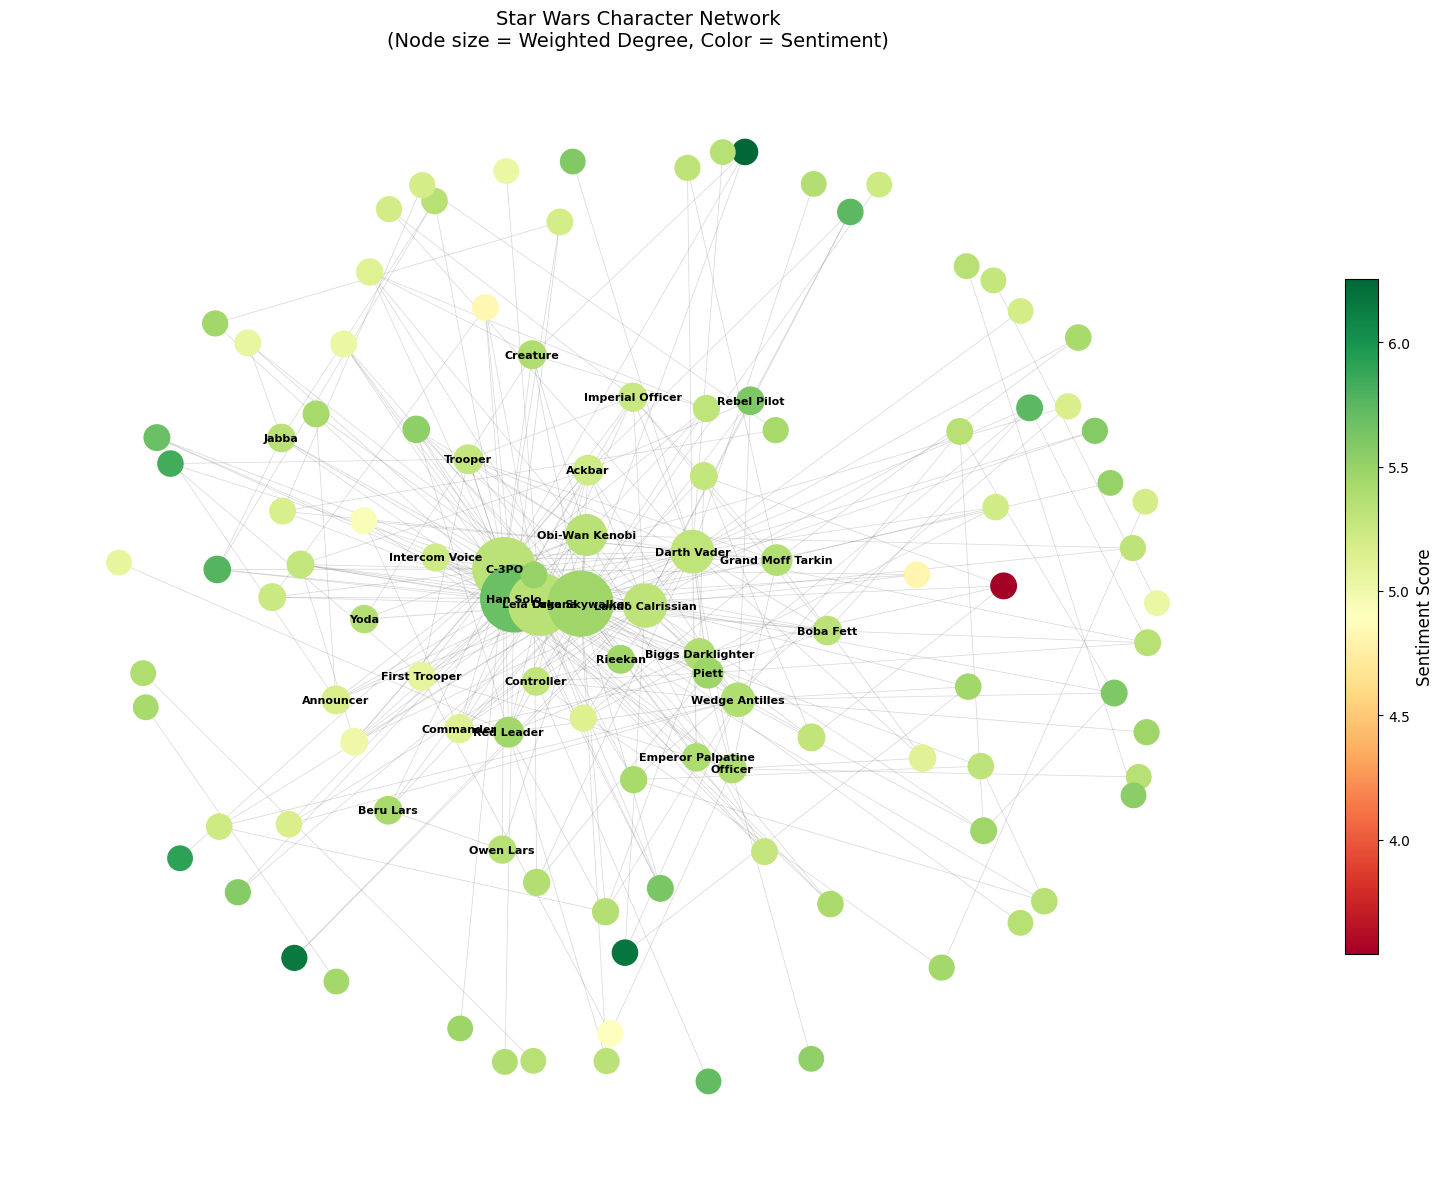

Sentiment range: 3.540 to 6.253


In [29]:
# Get sentiment values for coloring
sentiments = [G.nodes[n]["sentiment"] for n in G.nodes()]

# Replace None with median sentiment for visualization
valid_sentiments = [s for s in sentiments if s is not None]
median_sentiment = np.median(valid_sentiments)
sentiments_filled = [s if s is not None else median_sentiment for s in sentiments]

# Create color mapping
norm = Normalize(vmin=min(valid_sentiments), vmax=max(valid_sentiments))
cmap = cm.RdYlGn  # Red (negative) to Green (positive)
node_colors = [cmap(norm(s)) for s in sentiments_filled]

# Calculate node sizes based on degree
degrees = dict(G.degree(weight="weight"))
max_degree = max(degrees.values())
node_sizes = [300 + (degrees[n] / max_degree) * 2000 for n in G.nodes()]

# Use spring layout as ForceAtlas2 approximation (with weight consideration)
# NetworkX's spring_layout is similar to ForceAtlas2
pos = nx.spring_layout(G, k=2, iterations=100, seed=42, weight="weight")

# Visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Draw edges with varying alpha based on weight
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
max_weight = max(edge_weights)
edge_alphas = [0.1 + 0.5 * (w / max_weight) for w in edge_weights]

nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.3,
    width=[0.5 + 2 * (w / max_weight) for w in edge_weights],
    edge_color="gray",
    ax=ax,
)

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=sentiments_filled,
    node_size=node_sizes,
    cmap=cmap,
    vmin=min(valid_sentiments),
    vmax=max(valid_sentiments),
    ax=ax,
)

# Add labels for major characters (high degree)
degree_threshold = np.percentile(list(degrees.values()), 75)
labels = {n: n for n in G.nodes() if degrees[n] >= degree_threshold}
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight="bold", ax=ax)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label("Sentiment Score", fontsize=12)

ax.set_title(
    "Star Wars Character Network\n(Node size = Weighted Degree, Color = Sentiment)",
    fontsize=14,
)
ax.axis("off")
plt.tight_layout()
plt.savefig(
    "../figures/network_sentiment_visualization.png", dpi=150, bbox_inches="tight"
)
plt.show()

print(f"Sentiment range: {min(valid_sentiments):.3f} to {max(valid_sentiments):.3f}")

## 3. Community Detection Analysis

### Approach 1: Sentiment-Based Communities
Grouping characters into communities based on their sentiment scores (low, medium, high sentiment).

In [28]:
# Sentiment-based community detection
# Use tertiles to create 3 sentiment-based communities

# Get valid sentiments and compute tertile thresholds
valid_sentiment_nodes = [
    (n, G.nodes[n]["sentiment"])
    for n in G.nodes()
    if G.nodes[n]["sentiment"] is not None
]
sentiment_values = sorted([s for _, s in valid_sentiment_nodes])

# Calculate tertile thresholds
tertile_1 = np.percentile(sentiment_values, 33.33)
tertile_2 = np.percentile(sentiment_values, 66.67)

print(f"Sentiment tertile thresholds: {tertile_1:.3f}, {tertile_2:.3f}")

# Assign nodes to sentiment-based communities
sentiment_communities = {0: set(), 1: set(), 2: set()}  # Low, Medium, High sentiment

for node in G.nodes():
    sentiment = G.nodes[node]["sentiment"]
    if sentiment is None:
        sentiment = median_sentiment  # Use median for missing values

    if sentiment <= tertile_1:
        sentiment_communities[0].add(node)
    elif sentiment <= tertile_2:
        sentiment_communities[1].add(node)
    else:
        sentiment_communities[2].add(node)

# Convert to list of sets for modularity calculation
sentiment_community_list = [sentiment_communities[i] for i in range(3)]

print("\nSentiment-based communities:")
print(
    f"  - Low sentiment (≤{tertile_1:.3f}): {len(sentiment_communities[0])} characters"
)
print(
    f"  - Medium sentiment ({tertile_1:.3f}-{tertile_2:.3f}): {len(sentiment_communities[1])} characters"
)
print(
    f"  - High sentiment (>{tertile_2:.3f}): {len(sentiment_communities[2])} characters"
)

Sentiment tertile thresholds: 5.286, 5.430

Sentiment-based communities:
  - Low sentiment (≤5.286): 35 characters
  - Medium sentiment (5.286-5.430): 44 characters
  - High sentiment (>5.430): 34 characters


### Approach 2: Louvain Community Detection
Using NetworkX's Louvain algorithm which optimizes modularity to find communities based on network structure.

In [31]:
# Louvain community detection
louvain_communities_result = louvain_communities(G, weight="weight", seed=42)

print(f"Louvain detected {len(louvain_communities_result)} communities:\n")
for i, community in enumerate(louvain_communities_result):
    print(f"Community {i+1} ({len(community)} members):")
    # Show first 10 members sorted by degree
    members_by_degree = sorted(community, key=lambda x: degrees[x], reverse=True)[:5]
    print(f"  Top members: {', '.join(members_by_degree)}")

Louvain detected 9 communities:

Community 1 (22 members):
  Top members: Han Solo, C-3PO, Leia Organa, Rieekan, Announcer
Community 2 (18 members):
  Top members: Lando Calrissian, Wedge Antilles, Ackbar, Rebel Pilot, Controller
Community 3 (2 members):
  Top members: Second Commander, Control Room Commander
Community 4 (34 members):
  Top members: Darth Vader, Grand Moff Tarkin, Piett, Trooper, Boba Fett
Community 5 (2 members):
  Top members: Gold Five, Massassi Intercom Voice
Community 6 (4 members):
  Top members: Derlin, Hobbie, Pilots, Lieutenant
Community 7 (2 members):
  Top members: Rebel Captain, Rebel Fighter
Community 8 (27 members):
  Top members: Luke Skywalker, Obi-Wan Kenobi, Biggs Darklighter, Red Leader, Creature
Community 9 (2 members):
  Top members: Red Nine, Porkins


### Modularity Comparison

In [34]:
# Calculate modularity for both community detection approaches
modularity_sentiment = modularity(G, sentiment_community_list, weight="weight")
modularity_louvain = modularity(G, louvain_communities_result, weight="weight")

# Create comparison table
comparison_data = {
    "Community Detection Method": [
        "Sentiment-Based (3 communities)",
        f"Louvain ({len(louvain_communities_result)} communities)",
    ],
    "Number of Communities": [3, len(louvain_communities_result)],
    "Modularity": [f"{modularity_sentiment:.4f}", f"{modularity_louvain:.4f}"],
}

comparison_df = pd.DataFrame(comparison_data)
print("MODULARITY COMPARISON:")
print(comparison_df.to_string(index=False))

MODULARITY COMPARISON:
     Community Detection Method  Number of Communities Modularity
Sentiment-Based (3 communities)                      3    -0.0940
        Louvain (9 communities)                      9     0.3334


## 4. Community Visualization

Visualizing both community detection approaches side by side.

/var/folders/z6/1_6w7ytj0hx2sfx4vdyhj6g00000gn/T/ipykernel_6643/1969694702.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10" if n_communities <= 10 else "tab20")


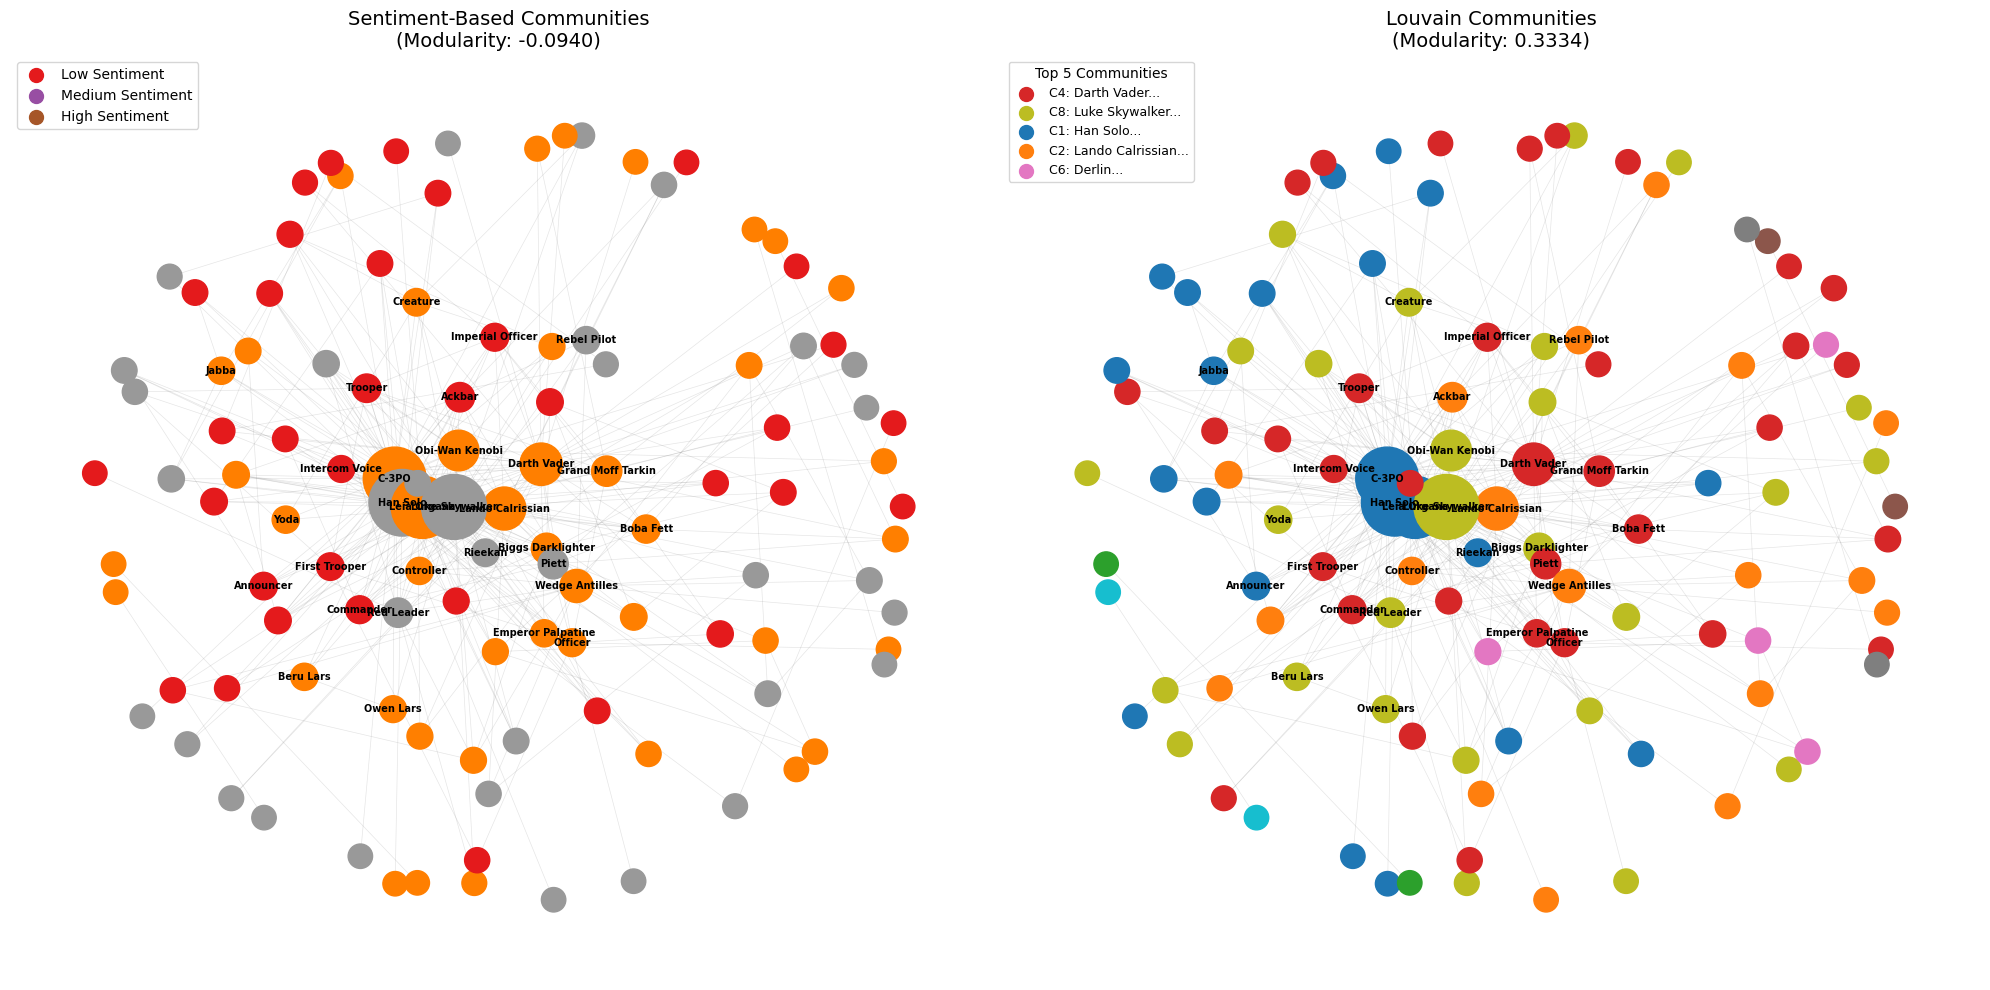

In [35]:
# Create node-to-community mappings
sentiment_node_community = {}
for comm_id, community in enumerate(sentiment_community_list):
    for node in community:
        sentiment_node_community[node] = comm_id

louvain_node_community = {}
for comm_id, community in enumerate(louvain_communities_result):
    for node in community:
        louvain_node_community[node] = comm_id


# Create colors for communities
def get_community_colors(node_community_map, n_communities):
    """Generate distinct colors for each community."""
    cmap = cm.get_cmap("tab10" if n_communities <= 10 else "tab20")
    colors = [cmap(node_community_map[node] / n_communities) for node in G.nodes()]
    return colors


# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# ========== Sentiment-based communities ==========
ax1 = axes[0]
sentiment_colors = get_community_colors(sentiment_node_community, 3)

nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, edge_color="gray", ax=ax1)
nodes1 = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=[sentiment_node_community[n] for n in G.nodes()],
    node_size=node_sizes,
    cmap=cm.Set1,
    vmin=0,
    vmax=2,
    ax=ax1,
)
nx.draw_networkx_labels(G, pos, labels, font_size=7, font_weight="bold", ax=ax1)

ax1.set_title(
    f"Sentiment-Based Communities\n(Modularity: {modularity_sentiment:.4f})",
    fontsize=14,
)
ax1.axis("off")

# Add legend for sentiment communities
sentiment_labels = ["Low Sentiment", "Medium Sentiment", "High Sentiment"]
sentiment_cmap = cm.Set1
for i, label in enumerate(sentiment_labels):
    ax1.scatter([], [], c=[sentiment_cmap(i / 3)], s=100, label=label)
ax1.legend(loc="upper left", fontsize=10)

# ========== Louvain communities ==========
ax2 = axes[1]
n_louvain = len(louvain_communities_result)

nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, edge_color="gray", ax=ax2)
nodes2 = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=[louvain_node_community[n] for n in G.nodes()],
    node_size=node_sizes,
    cmap=cm.tab10,
    vmin=0,
    vmax=n_louvain - 1,
    ax=ax2,
)
nx.draw_networkx_labels(G, pos, labels, font_size=7, font_weight="bold", ax=ax2)

ax2.set_title(
    f"Louvain Communities\n(Modularity: {modularity_louvain:.4f})", fontsize=14
)
ax2.axis("off")

# Add legend for Louvain communities (top 5 by size)
sorted_communities = sorted(
    enumerate(louvain_communities_result), key=lambda x: len(x[1]), reverse=True
)
louvain_cmap = cm.tab10
for idx, (comm_id, community) in enumerate(sorted_communities[:5]):
    top_member = max(community, key=lambda x: degrees[x])
    ax2.scatter(
        [],
        [],
        c=[louvain_cmap(comm_id / (n_louvain - 1))],
        s=100,
        label=f"C{comm_id+1}: {top_member}...",
    )
ax2.legend(loc="upper left", fontsize=9, title="Top 5 Communities")

plt.tight_layout()
plt.savefig("../figures/community_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## Summary

### Key Findings:

1. **Network Structure**: The Star Wars character network contains 113 characters with 313 weighted edges. The main characters (Han Solo, C-3PO, Leia Organa, Luke Skywalker) form the core of the network.

2. **Sentiment Distribution**: Character sentiment scores range from 3.54 to 6.25, with most characters clustered around 5.2-5.5.

3. **Community Detection Comparison**:
   - **Sentiment-Based**: Dividing characters by sentiment tertiles yields a negative modularity (-0.094), indicating that sentiment does not align well with the network's structural communities.
   - **Louvain Algorithm**: Detects 9 communities with positive modularity (0.333), revealing meaningful structural groups such as:
     - Imperial characters (Darth Vader, Grand Moff Tarkin, Piett)
     - Rebel heroes (Luke Skywalker, Obi-Wan Kenobi)
     - Main trio and associates (Han Solo, C-3PO, Leia Organa)
     - Rebel fleet (Lando Calrissian, Wedge Antilles, Ackbar)

The Louvain algorithm significantly outperforms sentiment-based clustering, confirming that character interactions in the movies form natural structural communities that don't necessarily correlate with their dialogue sentiment.